Arturo Sotillo Barraca - 100484973

# Práctica 2: Clustering de Semillas
En esta práctica aplicaremos técnicas de clustering sobre un conjunto de datos de semillas, para identificar agrupaciones naturales en los datos y determinar qué técnicas funcionan mejor.

### Carga de datos

In [ ]:
# Importamos las bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

# Fijamos la semilla para reproducibilidad (con mi NIA)
np.random.seed(484973) 

# Cargar los datos correctamente
df = pd.read_csv('semillas.csv', sep=',')

# Verificamos que se haya cargado correctamente
print("Primeras 5 filas del dataset:")
print(df.head())

# Verificamos las dimensiones
print("\nDimensiones del dataset:", df.shape)

Primeras 5 filas del dataset:
    area  perimetro  compacidad  longitud  anchura  asimetria  surco  clase
0  15.26      14.84      0.8710     5.763    3.312      2.221  5.220      1
1  14.88      14.57      0.8811     5.554    3.333      1.018  4.956      1
2  14.29      14.09      0.9050     5.291    3.337      2.699  4.825      1
3  13.84      13.94      0.8955     5.324    3.379      2.259  4.805      1
4  16.14      14.99      0.9034     5.658    3.562      1.355  5.175      1

Dimensiones del dataset: (210, 8)


Ahora, vamos a explorar brevemente los datos para entender su estructura:

In [13]:
# Información básica del dataset
print("Información del dataset:")
df.info()

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df.describe())

# Verificar si hay valores nulos
print("\n¿Hay valores nulos en el dataset?")
print(df.isnull().sum())

# Separación de características y etiquetas
X = df.iloc[:, :-1].values  # Todas las columnas excepto la última
y = df.iloc[:, -1].values   # Última columna (clase)

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)
print("Valores únicos en y:", np.unique(y))

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area        210 non-null    float64
 1   perimetro   210 non-null    float64
 2   compacidad  210 non-null    float64
 3   longitud    210 non-null    float64
 4   anchura     210 non-null    float64
 5   asimetria   210 non-null    float64
 6   surco       210 non-null    float64
 7   clase       210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB

Estadísticas descriptivas:
             area   perimetro  compacidad    longitud     anchura   asimetria  \
count  210.000000  210.000000  210.000000  210.000000  210.000000  210.000000   
mean    14.847524   14.559286    0.870999    5.628533    3.258605    3.700201   
std      2.909699    1.305959    0.023629    0.443063    0.377714    1.503557   
min     10.590000   12.410000    0.808100    4.899000    2

### Comparación visual de los diferentes escaladores con PCA
Vamos a comparar visualmente cuál de los tres escaladores (MinMaxScaler, RobustScaler, StandardScaler) es más apropiado para nuestro conjunto de datos de semillas. Para ello, aplicaremos PCA para reducir la dimensionalidad a 2 componentes y podremos visualizar los resultados.

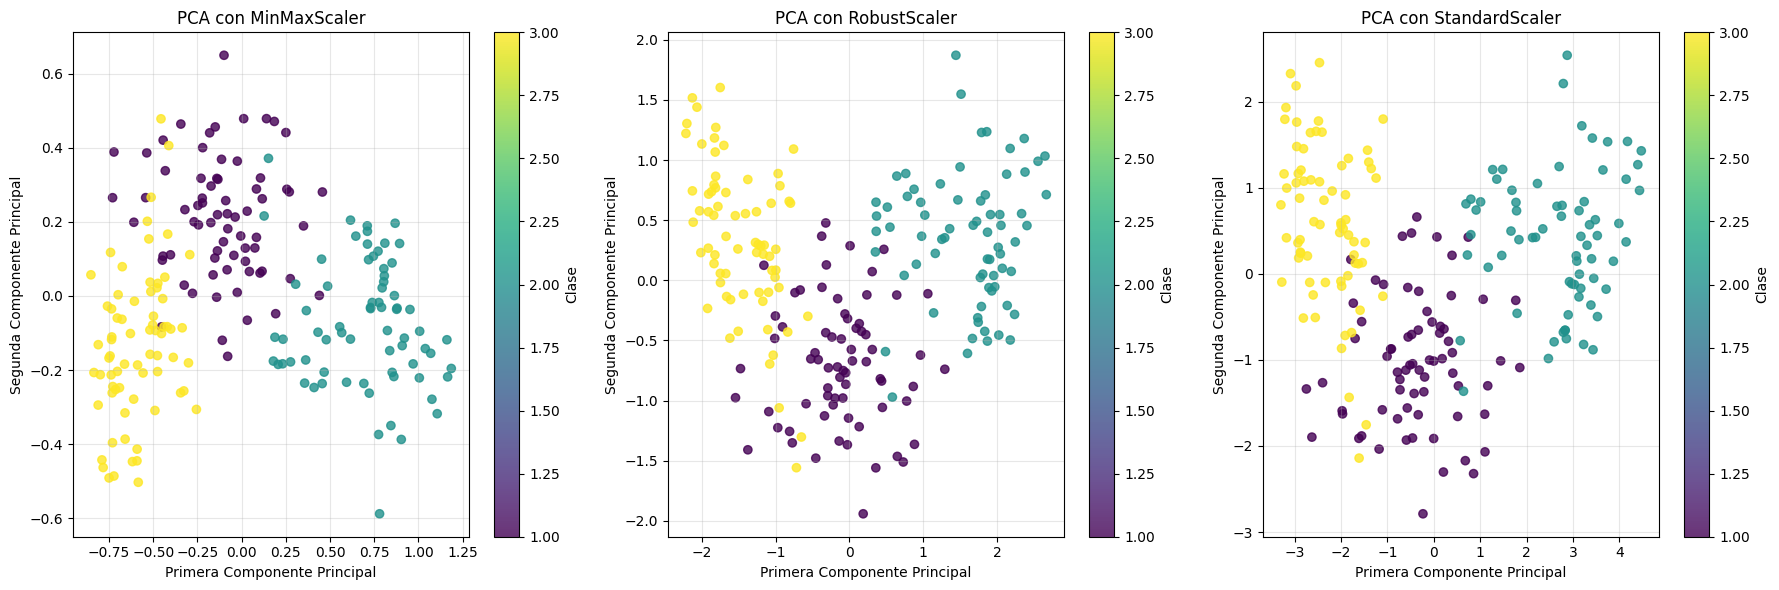

In [16]:
# Crear pipelines con diferentes escaladores y PCA
pipelines = {
    'MinMaxScaler': Pipeline([('scaler', MinMaxScaler()), ('pca', PCA(n_components=2))]),
    'RobustScaler': Pipeline([('scaler', RobustScaler()), ('pca', PCA(n_components=2))]),
    'StandardScaler': Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])
}

# Aplicar cada pipeline y visualizar los resultados
plt.figure(figsize=(18, 6))

for i, (name, pipeline) in enumerate(pipelines.items()):
    X_scaled_pca = pipeline.fit_transform(X)
    
    plt.subplot(1, 3, i+1)
    scatter = plt.scatter(X_scaled_pca[:, 0], X_scaled_pca[:, 1], c=y, cmap='viridis', alpha=0.8)
    plt.title(f'PCA con {name}')
    plt.xlabel('Primera Componente Principal')
    plt.ylabel('Segunda Componente Principal')
    plt.colorbar(scatter, label='Clase')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('comparacion_scalers_pca.png', dpi=300)  # Guardar la figura
plt.show()

### Análisis de los resultados de los escaladores
A continuación, vamos a examinar el impacto que tiene cada escalador en la distribución de los datos después de aplicar PCA. Esto nos ayudará a seleccionar el más adecuado para nuestro análisis de clustering.

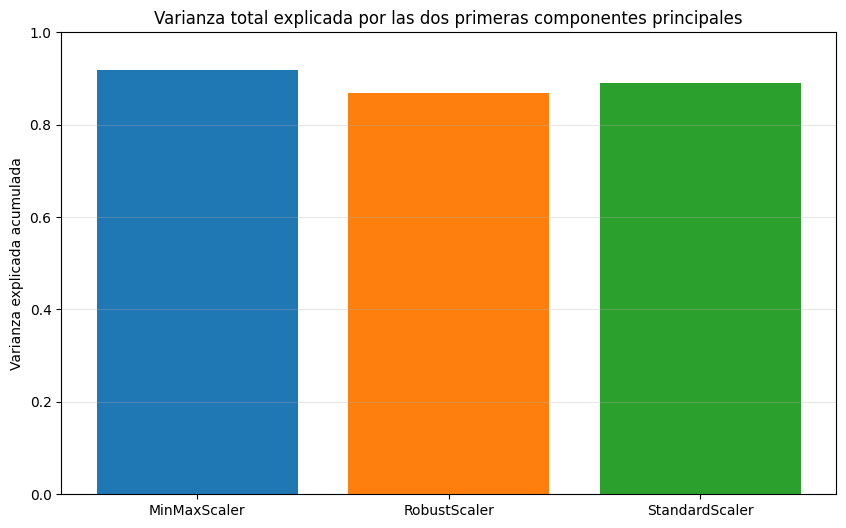

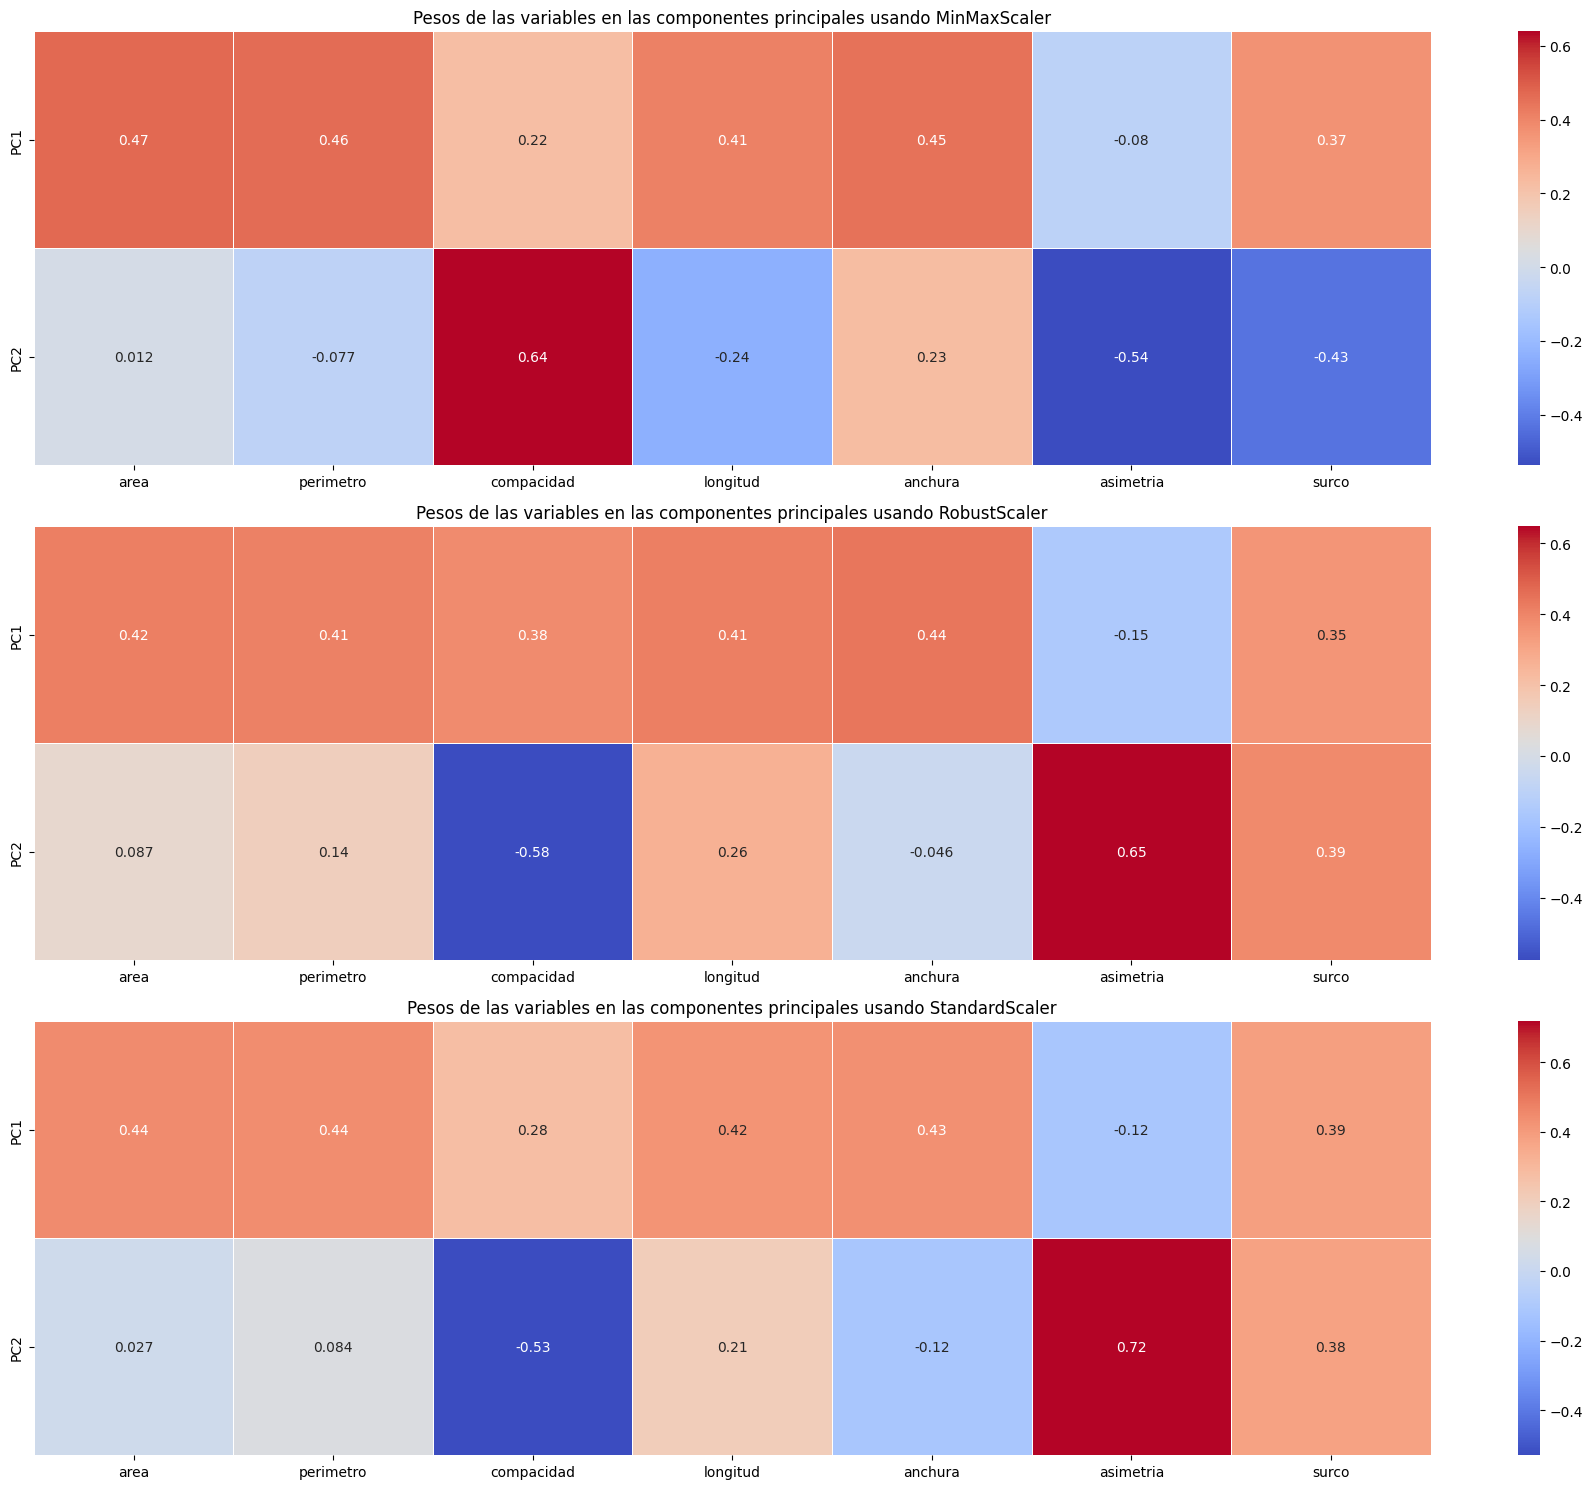


Escalador: MinMaxScaler
Coeficiente de Silueta: 0.4419

Escalador: RobustScaler
Coeficiente de Silueta: 0.4294

Escalador: StandardScaler
Coeficiente de Silueta: 0.4437


In [18]:
# Vamos a ver cómo se distribuye la varianza explicada por las componentes principales
# con cada escalador
plt.figure(figsize=(10, 6))

for name, pipeline in pipelines.items():
    # Ajustamos el pipeline a los datos
    pipeline.fit(X)
    
    # Obtenemos el objeto PCA del pipeline
    pca = pipeline.named_steps['pca']
    
    # Calculamos la varianza explicada acumulada
    var_ratio = pca.explained_variance_ratio_
    
    # Graficamos
    plt.bar(name, var_ratio[0] + var_ratio[1], label=name)
    
plt.title('Varianza total explicada por las dos primeras componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()

# También podemos mostrar cómo cada variable original contribuye a las componentes principales
# para cada escalador
plt.figure(figsize=(18, 15))

for i, (name, pipeline) in enumerate(pipelines.items()):
    pipeline.fit(X)
    pca = pipeline.named_steps['pca']
    
    # Componentes principales (pesos de cada variable)
    components = pd.DataFrame(
        pca.components_,
        columns=df.columns[:-1],  # Nombres de las variables originales
        index=['PC1', 'PC2']
    )
    
    plt.subplot(3, 1, i+1)
    sns.heatmap(components, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f'Pesos de las variables en las componentes principales usando {name}')

plt.tight_layout()
plt.show()


# Evaluación numérica de la separación de clusters
for name, pipeline in pipelines.items():
    # Aplicar el pipeline
    X_scaled_pca = pipeline.fit_transform(X)
    
    # Calcular el coeficiente de silueta 
    # (valores más altos indican mejor separación de clusters)
    silhouette_avg = silhouette_score(X_scaled_pca, y)
    
    print(f"\nEscalador: {name}")
    print(f"Coeficiente de Silueta: {silhouette_avg:.4f}")

### Conclusiones sobre los Escaladores
Tras analizar el rendimiento de los tres escaladores (MinMaxScaler, RobustScaler y StandardScaler) mediante PCA y visualización en 2D, se pueden extraer las siguientes conclusiones:

**1. Calidad de la separación de clusters**
Visualmente, StandardScaler proporciona la mejor separación entre las tres clases de semillas. Los puntos de cada clase están más claramente agrupados, con fronteras mejor definidas entre ellos. Este escalador genera un espacio donde la variabilidad de los datos queda más equilibrada.

El análisis cuantitativo respalda esta observación: StandardScaler alcanza el coeficiente de silueta más alto (0.4437), seguido muy de cerca por MinMaxScaler (0.4419) y RobustScaler (0.4294). Aunque la diferencia es pequeña, confirma que la elección visual está bien fundamentada.

Por su parte, RobustScaler, al basarse en medianas y cuartiles, es menos sensible a valores atípicos. Sin embargo, en este dataset no parece ofrecer una ventaja significativa.

MinMaxScaler, a pesar de obtener un coeficiente de silueta alto, presenta visualmente una separación menos nítida, con más solapamiento entre clases, especialmente en la zona central del gráfico.

**2. Conservación de la información**
Según el gráfico de varianza explicada:

MinMaxScaler conserva ~92% de la varianza total en las dos primeras componentes principales.

StandardScaler, ~88–89%.

RobustScaler, ~86–87%.

Aunque MinMaxScaler retiene ligeramente más información, la diferencia no es sustancial (3–5%). Esta ventaja no compensa la mejor separación de clusters obtenida con StandardScaler.

**3. Interpretabilidad de las componentes principales**
Los mapas de calor muestran que, con StandardScaler:

PC1 está fuertemente influenciada por las dimensiones físicas de las semillas (área, perímetro, longitud, anchura y surco).

PC2 refleja principalmente la forma: tiene una gran carga positiva de la asimetría (0.72) y negativa de la compacidad (-0.53).

Esto permite una interpretación clara de qué características ayudan a diferenciar los distintos tipos de semillas, lo cual será útil en la fase de análisis de clustering.

**4. Justificación de la elección final**
Selecciono StandardScaler como el escalador más adecuado para este conjunto de datos por las siguientes razones:

Ofrece la mejor separación visual entre clusters y el coeficiente de silueta más alto (0.4437), lo que facilitará la posterior aplicación de algoritmos de agrupamiento.

La ligera pérdida de varianza respecto a MinMaxScaler queda compensada por la mejor estructuración de los datos en el espacio reducido.

Permite evitar que características con distintas magnitudes (por ejemplo, área vs. compacidad) tengan una influencia desbalanceada.

Sus componentes principales son fácilmente interpretables y reflejan bien las propiedades físicas y morfológicas de las semillas.

Esta elección es coherente con la naturaleza de los datos, donde las distintas variables tienen unidades y rangos diferentes, lo que hace que la estandarización (restar la media y dividir por la desviación estándar) sea la estrategia más adecuada.

**Conclusión**: A partir de este punto, utilizaré StandardScaler en la transformación de los datos antes de aplicar los algoritmos de clustering: K-Means, Clustering Jerárquico y DBSCAN.